# Einleitung

In [1]:
%matplotlib inline
from IPython.display import display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3

import sys, os
sys.path.append("/Python")
from myfunctions import *
from parula import *

con = sqlite3.connect("../data/CongoDB.sqlite")

### Grenzen des Arbeitsgebietes

In [2]:
sql = """SELECT
           t_Ort.ort_kurz,
           t_Ort."Kat-Nr",
           t_Ort.y_lat,
           t_Ort.x_long
       FROM t_Ort
       WHERE ((t_Ort.ort_lit) Like '%DS%')""".replace('\n',' ')

df = pd.read_sql(sql, con)
df['x_long'] = df['x_long'].convert_objects(convert_numeric=True)
df['y_lat'] = df['y_lat'].convert_objects(convert_numeric=True)
# display(df.head())

C:\Users\Dirk\Anaconda3\lib\site-packages\ipykernel\__main__.py:10: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
C:\Users\Dirk\Anaconda3\lib\site-packages\ipykernel\__main__.py:11: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


In [3]:
pd.Series({'X/Länge - Minimum':np.min(df['x_long']),
           'X/Länge - Maximum':np.max(df['x_long']),
           'Y/Breite - Minimum':np.min(df['y_lat']),
           'Y/Breite - Maximum':np.max(df['y_lat'])})

X/Länge - Maximum     19.976358
X/Länge - Minimum     15.536524
Y/Breite - Maximum     5.133947
Y/Breite - Minimum    -1.117121
dtype: float64

In [4]:
# Umrechnung von Dezimalgrad in Grad/Minute/Sekunde
# siehe http://anothergisblog.blogspot.de/2011/11/convert-decimal-degree-to-degrees.html
# def decimalDegrees2DMS(value,type):
# in myfunctions.py 18.6.17

In [5]:
pd.Series({'X/Länge - Minimum':decimalDegrees2DMS(np.min(df['x_long']), 'Longitude'),
           'X/Länge - Maximum':decimalDegrees2DMS(np.max(df['x_long']), 'Longitude'),
           'Y/Breite - Minimum':decimalDegrees2DMS(np.min(df['y_lat']), 'Latitude'),
           'Y/Breite - Maximum':decimalDegrees2DMS(np.max(df['y_lat']), 'Latitude')})

X/Länge - Maximum     19º 58' 34.88'' E
X/Länge - Minimum     15º 32' 11.48'' E
Y/Breite - Maximum      5º 8' 2.209'' N
Y/Breite - Minimum     -1º 7' 1.635'' S
dtype: object

## Kartierung

In [6]:
# Liste mit eigenen FdSt und denen aus Wotzka 1995
sql = """SELECT
           t_Ort.ort_name,
           t_Ort.y_lat,
           t_Ort.x_long,
           t_Ort."Kat-Nr",
           t_Ort.ort_lit
       FROM t_Ort
       WHERE (((t_Ort.y_lat) <> '')
           AND ((t_Ort.ort_lit) Like '%DS%')
           OR ((t_Ort.ort_lit) Like '%Wotzka 1995%'))""".replace('\n',' ')

df1 = pd.read_sql(sql, con)

# Liste mit mit allen anderen FdSt
sql = """SELECT
           t_Ort.ort_name,
           t_Ort.y_lat,
           t_Ort."Kat-Nr",
           t_Ort.x_long
       FROM t_Ort
       WHERE (((t_Ort.y_lat) <> '')
           AND ((t_Ort.ort_lit) Not Like '%DS%')
           AND ((t_Ort.ort_lit) Not Like '%Wotzka 1995%'))""".replace('\n',' ')

df2 = pd.read_sql(sql, con)
df2['ort_lit'] = 'Sonstige'   # die verschiedene Einträge in ort_lit werden vereinheitlicht
# display(df2.head())

In [7]:
# die beiden Listen aneinanderhängen
df = df1.append(df2,ignore_index = True)

In [8]:
df.to_csv('../data/processed/1 Fundstellen - Kartierung.csv', index = False, encoding='utf-8')

In [9]:
# Auswahl der eigenen FdSt & zwischenspeichern
df1 = df.loc[(df['ort_lit'] == 'DS')]
df1.to_csv('../data/processed/1 Fundstellen DS - Kartierung.csv', index = False, encoding='utf-8')

> Kartierung in QGIS od R

### Höhe der FdSt

in QGIS die Höhe der FdSt aus dem SRMT abgeleitet (<code>Point Sampling Tool</code>-Erweiterung) und als <code>.shp</code> abgespeichert; dieses dann als <code>.csv</code> exportiert

In [10]:
df = pd.read_csv('../data/processed/1_Fundstellen_Kartierung_Höhe.csv')
display(df.head())

,X,Y,ort_name,y_lat,x_long,ort_lit,srtm_merge
0,17.580406,-0.704069,Gombe,-0.704069,17.580406,DS,302
1,19.269369,0.347772,Mondjo,0.347772,19.269369,Wotzka 1995,317
2,17.432057,-0.006791,Bojenjo,-0.006791,17.432057,DS,309
3,17.478148,0.099491,Bokuma,0.099491,17.478148,DS,302
4,17.221926,-0.805556,Boleko,-0.805556,17.221926,DS,304


In [11]:
# nur die eigenen FdSt aus dem Datensatz herausfiltern
df_DS = df.loc[(df['ort_lit'] == 'DS')]
# Sortierung ändern
df_DS = df_DS.sort('srtm_merge', ascending = True)

Kennwerte

In [12]:
df_DS['srtm_merge'].describe()

count    123.000000
mean     331.073171
std       25.062601
min      289.000000
25%      311.000000
50%      330.000000
75%      350.000000
max      390.000000
Name: srtm_merge, dtype: float64

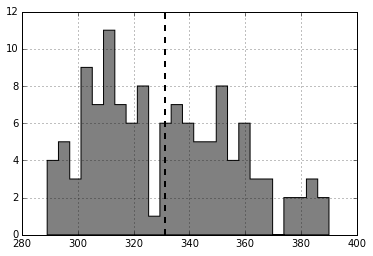

In [13]:
bins = df_DS['srtm_merge'].max() - df_DS['srtm_merge'].min()
mean = df_DS['srtm_merge'].mean()

df_DS['srtm_merge'].hist(bins = 25, color = 'grey', histtype = 'stepfilled')
plt.axvline(mean, color='black', lw = 2, ls = '--')

(280, 400)

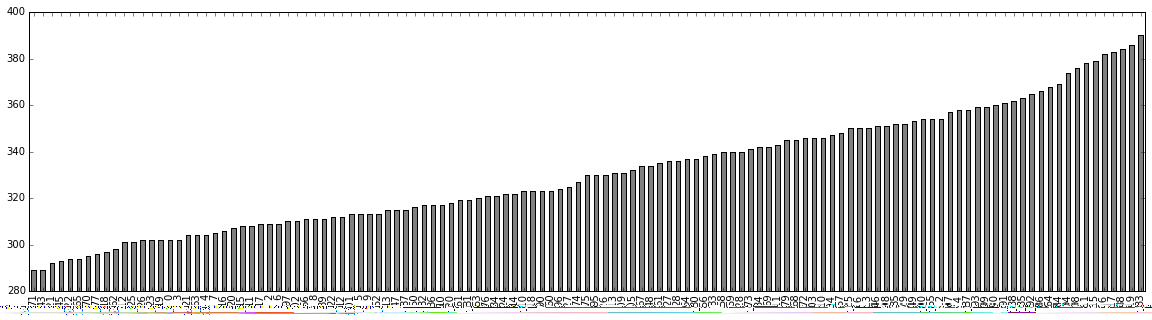

In [14]:
fig = plt.figure(1)
fig.set_size_inches(20, 5)
df_DS['srtm_merge'].plot(kind = 'bar', color = 'grey')
plt.ylim([280,400]) 

## Liste der Fundorte (Fpl.)-Nummern

In [2]:
sql = """SELECT
           t_Ort.ort_kurz,
           t_Ort.ort_name,
           t_Ort."Kat-Nr",
           t_Ort.ort_lit
       FROM t_Ort
       WHERE ((t_Ort.ort_lit) Like '%DS%')""".replace('\n',' ')

df = pd.read_sql(sql, con)
df = df.sort_index(by=['ort_name'], ascending=[True])
df.to_csv('../data/processed/1 Fundstellen - Fpl-Nr-Liste.csv', index = False, encoding='utf-8')

C:\Users\DirkSeidenticker\Anaconda3\lib\site-packages\IPython\kernel\__main__.py:10: FutureWarning: by argument to sort_index is deprecated, pls use .sort_values(by=...)


In [3]:
df

,ort_kurz,ort_name,Kat-Nr,ort_lit
1,MBD,?,None,DS
74,BLN,Balongoi,214,DS
70,BAN,Bangui,215,DS
71,BAT,Batanga,209,DS
42,BIL,Bili,254,DS
78,BOB,Bobangi,189,DS
72,BBL,Bobulu,198,DS
35,BBS,Bobusa,239,DS
79,BOD,Boduna,225,DS
16,BNJ,Boenja,294,DS


## Grenzen Arbeitsgebiete:

In [6]:
sql = """SELECT
           t_Ort.ort_kurz,
           t_Ort."Kat-Nr",
           t_Ort.y_lat,
           t_Ort.x_long
       FROM t_Ort
       WHERE ((t_Ort.ort_lit) Like '%DS%')""".replace('\n',' ')

df = pd.read_sql(sql, con)
df['x_long'] = df['x_long'].convert_objects(convert_numeric=True)
df['y_lat'] = df['y_lat'].convert_objects(convert_numeric=True)

pd.Series({'X/Länge - Minimum':np.min(df['x_long']),
           'X/Länge - Maximum':np.max(df['x_long']),
           'Y/Breite - Minimum':np.min(df['y_lat']),
           'Y/Breite - Maximum':np.max(df['y_lat'])})

C:\Users\Dirk\Anaconda3\lib\site-packages\ipykernel\__main__.py:10: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
C:\Users\Dirk\Anaconda3\lib\site-packages\ipykernel\__main__.py:11: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


X/Länge - Maximum     19.976358
X/Länge - Minimum     15.536524
Y/Breite - Maximum     5.133947
Y/Breite - Minimum    -1.117121
dtype: float64

In [7]:
sql = """SELECT
           t_Ort.ort_kurz,
           t_Ort."Kat-Nr",
           t_Ort.y_lat,
           t_Ort.x_long
       FROM t_Ort
       WHERE ((t_Ort.ort_lit) Like '%Wotzka 1995%')""".replace('\n',' ')

df = pd.read_sql(sql, con)
df['x_long'] = df['x_long'].convert_objects(convert_numeric=True)
df['y_lat'] = df['y_lat'].convert_objects(convert_numeric=True)

pd.Series({'X/Länge - Minimum':np.min(df['x_long']),
           'X/Länge - Maximum':np.max(df['x_long']),
           'Y/Breite - Minimum':np.min(df['y_lat']),
           'Y/Breite - Maximum':np.max(df['y_lat'])})

C:\Users\Dirk\Anaconda3\lib\site-packages\ipykernel\__main__.py:10: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
C:\Users\Dirk\Anaconda3\lib\site-packages\ipykernel\__main__.py:11: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


X/Länge - Maximum     24.086096
X/Länge - Minimum     17.702895
Y/Breite - Maximum     2.174369
Y/Breite - Minimum    -2.031199
dtype: float64

In [8]:
pd.Series({'X/Länge - Minimum':decimalDegrees2DMS(np.min(df['x_long']), 'Longitude'),
           'X/Länge - Maximum':decimalDegrees2DMS(np.max(df['x_long']), 'Longitude'),
           'Y/Breite - Minimum':decimalDegrees2DMS(np.min(df['y_lat']), 'Latitude'),
           'Y/Breite - Maximum':decimalDegrees2DMS(np.max(df['y_lat']), 'Latitude')})

X/Länge - Maximum      24º 5' 9.945'' E
X/Länge - Minimum     17º 42' 10.42'' E
Y/Breite - Maximum     2º 10' 27.72'' N
Y/Breite - Minimum     -2º 1' 52.31'' S
dtype: object

In [24]:
sql = """SELECT
           t_Ort.ort_kurz,
           t_Ort."Kat-Nr",
           t_Ort.y_lat,
           t_Ort.x_long
       FROM t_Ort
       WHERE ((t_Ort.ort_lit) Like '%LivingstoneSmith.2017%')""".replace('\n',' ')

df = pd.read_sql(sql, con)
df['x_long'] = df['x_long'].convert_objects(convert_numeric=True)
df['y_lat'] = df['y_lat'].convert_objects(convert_numeric=True)

pd.Series({'X/Länge - Minimum':np.min(df['x_long']),
           'X/Länge - Maximum':np.max(df['x_long']),
           'Y/Breite - Minimum':np.min(df['y_lat']),
           'Y/Breite - Maximum':np.max(df['y_lat'])})

C:\Users\Dirk\Anaconda3\lib\site-packages\ipykernel\__main__.py:10: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
C:\Users\Dirk\Anaconda3\lib\site-packages\ipykernel\__main__.py:11: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


X/Länge - Maximum     25.160636
X/Länge - Minimum     22.672210
Y/Breite - Maximum     2.093850
Y/Breite - Minimum     0.649450
dtype: float64